# Imports

In [1]:
import numpy as np
import requests
import pandas as pd
import matplotlib.pyplot as plt
import time
import sys

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, plot_confusion_matrix, accuracy_score, classification_report,roc_curve, auc
from nltk import FreqDist, pos_tag
from nltk.tokenize import word_tokenize
from collections import Counter

from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, VotingClassifier, RandomForestClassifier, BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC

# Import CountVectorizer and TFIDFVectorizer from feature_extraction.text.
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from nltk.tokenize import sent_tokenize, word_tokenize, RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.stem.porter import PorterStemmer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk import FreqDist, pos_tag
import re

# Model

In [2]:
#read in cleaned data file
model_df = pd.read_csv('../data/model_df.csv')

In [3]:
#X = reddit_df.drop(columns = ['subreddit', 'selftext', 'score','created_utc'])
X_text = model_df[['all_text', 'sentiment']]
y = model_df['subreddit']

X_train, X_test, y_train, y_test = train_test_split(X_text,
                                                    y,
                                                    test_size=0.2,
                                                    stratify = y,
                                                    random_state=42)

In [4]:
print(len(X_test))
print(len(X_train))

4008
16028


# Baseline accuracy is 50%

In [5]:
# This is the baseline --> accuracy
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: subreddit, dtype: float64

In [6]:
# create functions to return needed columns
get_text_data = FunctionTransformer(lambda x: x['all_text'], validate = False)
get_numeric_data = FunctionTransformer(lambda x: x[['sentiment']], validate = False)

In [7]:
AdaBoostClassifier().get_params().keys()

dict_keys(['algorithm', 'base_estimator', 'learning_rate', 'n_estimators', 'random_state'])

In [9]:
pipe = Pipeline([
    ('features', FeatureUnion([
            ('numeric_features', Pipeline([
                ('selector', get_numeric_data),
                ('ss', StandardScaler())
            ])),
            ('text_features', Pipeline([
                ('selector', get_text_data),
                ('cvec', CountVectorizer(stop_words = 'english', max_features = 10000, lowercase = True))
            ]))
    ])),
    ('abc', AdaBoostClassifier())
])

params = {'abc__n_estimators': [100, 200],
  'abc__learning_rate': [0.001, 0.01, 0.1, 0.2, 0.5]
             }

gs = GridSearchCV(pipe, params, cv=5,verbose=2)

gs.fit(X_train, y_train)
gs.score(X_train, y_train)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
[CV] abc__learning_rate=0.001, abc__n_estimators=100 .................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .. abc__learning_rate=0.001, abc__n_estimators=100, total=   6.2s
[CV] abc__learning_rate=0.001, abc__n_estimators=100 .................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.1s remaining:    0.0s


[CV] .. abc__learning_rate=0.001, abc__n_estimators=100, total=   7.6s
[CV] abc__learning_rate=0.001, abc__n_estimators=100 .................
[CV] .. abc__learning_rate=0.001, abc__n_estimators=100, total=   7.4s
[CV] abc__learning_rate=0.001, abc__n_estimators=100 .................
[CV] .. abc__learning_rate=0.001, abc__n_estimators=100, total=   7.9s
[CV] abc__learning_rate=0.001, abc__n_estimators=100 .................
[CV] .. abc__learning_rate=0.001, abc__n_estimators=100, total=   7.0s
[CV] abc__learning_rate=0.001, abc__n_estimators=200 .................
[CV] .. abc__learning_rate=0.001, abc__n_estimators=200, total=  11.0s
[CV] abc__learning_rate=0.001, abc__n_estimators=200 .................
[CV] .. abc__learning_rate=0.001, abc__n_estimators=200, total=  11.4s
[CV] abc__learning_rate=0.001, abc__n_estimators=200 .................
[CV] .. abc__learning_rate=0.001, abc__n_estimators=200, total=  11.1s
[CV] abc__learning_rate=0.001, abc__n_estimators=200 .................
[CV] .

[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  8.1min finished


0.7229847766408785

In [10]:
gs.score(X_test, y_test)

0.7020958083832335

In [11]:
def nice_conmat(y_test, preds, classes):

    conmat = confusion_matrix(y_test, preds)
    print(f'Accuracy Score: {accuracy_score(y_test, preds)}')
    return pd.DataFrame(conmat, columns=['Predicted ' +class_ for class_ in classes], \
                index=['Actual '+ class_ for class_ in classes])

In [12]:
# build a function to print out a nice confusion matrix
preds = gs.best_estimator_.predict(X_test)

nice_conmat(y_test, preds, ['stockmarket', 'stocks'])

Accuracy Score: 0.7020958083832335


,Predicted stockmarket,Predicted stocks
Actual stockmarket,1635,369
Actual stocks,825,1179


In [13]:
# Get predictions
preds = gs.predict(X_test)
# Save confusion matrix values
tn, fp, fn, tp = confusion_matrix(y_test, preds).ravel()

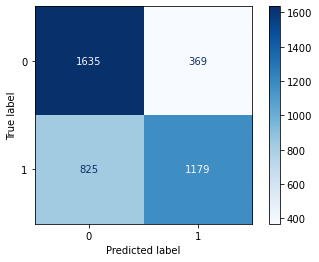

In [14]:
# View confusion matrix
plot_confusion_matrix(gs, X_test,y_test,cmap='Blues',values_format='d');

In [19]:
#Precision
#Poportion of corrct that are actually correct
precision = tp / (tp+fp)
print(f'Precision: {round(precision,2)}')

#Recall Rate or Sensitivity
#Percentage of true positives gotten correct
recall = tp/(tp + fn)
print(f'recall: {round(recall,2)}')

#the mean of precision and recall.
#mean of proportion that are predicted actually positive correctly and actually negative correctly
f1_score = (2*precision*recall)/ (precision + recall)
print(f'F1_Score: {round(f1_score,2)}')

 # Calculate the specificity TRUE NEG RATE
#percentage of true negatives gotten correct
specificity = tn/ (tn+fp)
print(f'Specificity: {round(specificity,2)}')

false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, preds)
roc_auc = auc(false_positive_rate, true_positive_rate)
print(f'ROC AUC: {round(roc_auc,2)}')

Precision: 0.76
recall: 0.59
F1_Score: 0.66
Specificity: 0.82
ROC AUC: 0.7


Wall time: 36.9 s


<AxesSubplot:>

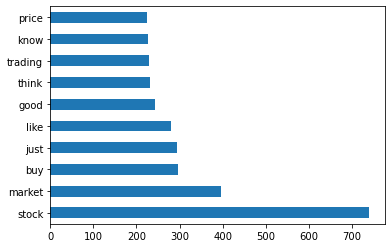

In [16]:
%%time

# Instantiate the transformer.
tvec = TfidfVectorizer(stop_words='english')

# convert training data to dataframe
X_train_df = pd.DataFrame(tvec.fit_transform(X_train['all_text']).todense(), 
                          columns=tvec.get_feature_names())
# plot top occuring words
X_train_df.sum().sort_values(ascending=False).head(10).plot(kind='barh');

In [17]:
#features variable:

features = ['sentiment'] +\
gs.best_estimator_.named_steps['features'].transformer_list[1][1].named_steps['cvec'].get_feature_names()

# no changes to our coefficient variable:
# I'm just bringing it down here
coefficients = gs.best_estimator_.named_steps['logreg'].coef_[0]

coef_df = pd.DataFrame({'features': features, 
              'coef' : coefficients,
              'exp_coef': [np.exp(coef) for coef in coefficients] #exponentiated coefficients
             })

coef_df

KeyError: 'logreg'

In [ ]:
coef_df = coef_df.set_index('features')
coef_df = coef_df.sort_values('exp_coef', ascending = False)
coef_df.head(10)

In [ ]:
coef_df['exp_coef'].head(10).sort_values()

In [ ]:
weights = coef_df['exp_coef'].head(10).sort_values()
labels = weights.index

plt.figure(figsize=(20,10))
plt.barh(labels, weights, color = 'red')
plt.yticks(fontsize=20)
plt.xticks(fontsize=20)
plt.xlabel('Exp Coef', fontsize=30)
plt.title(f'Top 10 Features - Stocks', fontsize=42)
plt.tight_layout()

In [ ]:
# 5 longest posts
model_df['all_text'].map(lambda x: len(x)).nlargest()

In [ ]:
model_df['all_text'].map(lambda x: len(x)).mean()

In [ ]:
# distribution of post length
model_df['all_text'].map(lambda x: len(x)).plot(kind='hist');